In [1]:
from langchain_cohere import ChatCohere

# === Initialize Agents ===
with open(f'api.txt', errors='ignore') as f:
    api_key = f.read()
    
llm = ChatCohere(cohere_api_key=api_key)

In [ ]:
# agent1_memory = [
#     SystemMessage(content="""You are Agent 1. You are playing a repeated Prisoner's Dilemma game against Agent 2. The prize at stake is substantial. 
#     You've faced difficult choices before, and you know that making the right move could change your life. You value achieving the best possible outcome for yourself, 
#     but you've learned that trust can be essential. Decide whether to 'Cooperate' or 'Defect' based on your understanding of the situation and what is at stake.""")
# ]

# agent2_memory = [
#     SystemMessage(content="""You are Agent 2. You are playing a repeated Prisoner's Dilemma game against Agent 1. Your decisions will directly impact your future stability.
#     The prize you're vying for could provide security, but betraying others could lead to long-term consequences. You need to weigh your options carefully and consider how much you can trust Agent 1. Decide whether to 'Cooperate' or 'Defect' based on your circumstances.""")
# ]

In [ ]:
# simple prisoner's dilemma arena without communication
import random
from typing import List, Tuple, TypedDict

from langchain.schema import SystemMessage, HumanMessage, AIMessage
from langgraph.graph import StateGraph, END

# === Define the Game State ===
class GameState(TypedDict):
    history: List[Tuple[str, str]]           # (agent1_move, agent2_move)
    scores: Tuple[int, int]                  # (agent1_score, agent2_score)
    round: int
    max_rounds: int
    current_move_1: str
    current_move_2: str

agent1_memory = [
    SystemMessage(content="You are Agent 1. You are playing repeated Prisoner's Dilemma against Agent 2. Begin with defect then follow tit for tat and respond ONLY with 'Cooperate' or 'Defect'. Never explain unless asked."),
]
agent2_memory = [
    SystemMessage(content="You are Agent 2. You are playing a repeated Prisoner's Dilemma against Agent 1. Choose to cooperate or defect. Explain your reasoning."),
]

# === Define Move Nodes ===
def agent1_move(state: GameState) -> GameState:
    if not state["history"]:
        prompt = "This is the first round. Do you choose 'Cooperate' or 'Defect'?"
    else:
        last_moves = state["history"][-1]
        prompt = f"Previously, you chose {last_moves[0]} and your opponent chose {last_moves[1]}. What do you choose now?"
    agent1_memory.append(HumanMessage(content=prompt))
    move = llm.invoke(agent1_memory).content.strip()
    agent1_memory.append(AIMessage(content=move))
    
    return {**state, "current_move_1": move}

def agent2_move(state: GameState) -> GameState:
    if not state["history"]:
        prompt = "This is the first round. Do you choose 'Cooperate' or 'Defect'?"
    else:
        last_moves = state["history"][-1]
        prompt = f"Previously, you chose {last_moves[1]} and your opponent chose {last_moves[0]}. What do you choose now?"
    agent2_memory.append(HumanMessage(content=prompt))
    move = llm.invoke(agent2_memory).content.strip()
    agent2_memory.append(AIMessage(content=move))
    
    return {**state, "current_move_2": move}


def confirm_agent1_move(state: GameState) -> GameState:
    move = state["current_move_1"]
    prompt = f"You chose '{move}'. Are you sure you want to stick with that decision? You may change your mind."
    print(f"Agent 1's Initial Move: {move}")
    
    agent1_memory.append(HumanMessage(content=prompt))
    confirmed_move = llm.invoke(agent1_memory).content.strip()
    agent1_memory.append(AIMessage(content=confirmed_move))
    
    print(f"Agent 1's Final Move: {confirmed_move}")
    print(f"\n")
    return {**state, "current_move_1": confirmed_move}

def confirm_agent2_move(state: GameState) -> GameState:
    move = state["current_move_2"]
    prompt = f"You chose '{move}'. Are you sure you want to stick with that decision? You may change your mind."
    print(f"Agent 2's Initial Move: {move}")
    
    agent2_memory.append(HumanMessage(content=prompt))
    confirmed_move = llm.invoke(agent2_memory).content.strip()
    agent2_memory.append(AIMessage(content=confirmed_move))
    
    print(f"Agent 2's Final Move: {confirmed_move}")
    print(f"\n")
    return {**state, "current_move_2": confirmed_move}



# === Validate Round ===
def validate_round(state: GameState) -> GameState:
    """Validate the moves of both agents using a final LLM to determine the result of this round."""

    move1 = state["current_move_1"]
    move2 = state["current_move_2"]

    # Construct the prompts for validation
    prompt_agent1 = f"Agent 1 chose {move1}. Based on the context of this game, should Agent 1 choose 'Cooperate' or 'Defect'?"
    print(f"Validation Prompt for Agent 1: {prompt_agent1}")
    
    prompt_agent2 = f"Agent 2 chose {move2}. Based on the context of this game, should Agent 2 choose 'Cooperate' or 'Defect'?"
    print(f"Validation Prompt for Agent 2: {prompt_agent2}")


    # Send the prompt for Agent 1's move to the LLM
    agent1_memory0 = [
        SystemMessage(content="You are an evaluator for a repeated Prisoner's Dilemma game. You will validate Agent 1's move based on the game context. Respond ONLY with 'Cooperate' or 'Defect'."),
        HumanMessage(content=prompt_agent1)
    ]
    
    # Send the prompt for Agent 2's move to the LLM
    agent2_memory0 = [
        SystemMessage(content="You are an evaluator for a repeated Prisoner's Dilemma game. You will validate Agent 2's move based on the game context. Respond ONLY with 'Cooperate' or 'Defect'."),
        HumanMessage(content=prompt_agent2)
    ]
    
    # Get the LLM's response for Agent 1's move
    agent1_validated_move = llm.invoke(agent1_memory0).content.strip()
    print(f"Response for Agent 1: {agent1_validated_move}")

    # Get the LLM's response for Agent 2's move
    agent2_validated_move = llm.invoke(agent2_memory0).content.strip()
    print(f"Response for Agent 2: {agent2_validated_move}")

    # Ensure both responses are valid ('Cooperate' or 'Defect')
    valid_moves = ['Cooperate', 'Defect']
    if agent1_validated_move not in valid_moves:
        raise ValueError(f"Invalid response for Agent 1: {agent1_validated_move}. It must be 'Cooperate' or 'Defect'.")
    if agent2_validated_move not in valid_moves:
        raise ValueError(f"Invalid response for Agent 2: {agent2_validated_move}. It must be 'Cooperate' or 'Defect'.")

    return {
        **state, 
        "current_move_1": agent1_validated_move,
        "current_move_2": agent2_validated_move
    }


# === Score Round ===
def score_round(state: GameState) -> GameState:
    if "current_move_1" not in state or "current_move_2" not in state:
        raise ValueError("Missing agent moves in state before scoring round")

    move1 = state["current_move_1"]
    move2 = state["current_move_2"]

    payoff = {
        ("Cooperate", "Cooperate"): (3, 3),
        ("Cooperate", "Defect"):    (0, 5),
        ("Defect", "Cooperate"):    (5, 0),
        ("Defect", "Defect"):       (1, 1)
    }

    score1, score2 = payoff.get((move1, move2), (0, 0))

    new_scores = (state["scores"][0] + score1, state["scores"][1] + score2)
    new_history = state["history"] + [(move1, move2)]
    new_round = state["round"] + 1

    # Print round summary
    print(f"\n=== Round {new_round} ===")
    print(f"Agent 1 move: {move1}")
    print(f"Agent 2 move: {move2}")
    print(f"Scores: Agent 1 = {new_scores[0]}, Agent 2 = {new_scores[1]}")
    print("-" * 40)

    return {
        **state,
        "scores": new_scores,
        "history": new_history,
        "round": new_round
    }

# === Check if Game Over ===
def check_game_over(state: GameState) -> str:
    print(f"Checking round {state['round']} / {state['max_rounds']}")
    print("\n")
    
    if state["round"] >= state["max_rounds"]:
        return END
    else:
        return "agent1_move"

# === Build the Graph ===
graph = StateGraph(GameState)

graph.add_node("agent1_move", agent1_move)
graph.add_node("agent2_move", agent2_move)
graph.add_node("score_round", score_round)
graph.add_node("validate_round", validate_round)
graph.add_node("confirm_agent1_move", confirm_agent1_move)
graph.add_node("confirm_agent2_move", confirm_agent2_move)

graph.set_entry_point("agent1_move")
graph.add_edge("agent1_move", "confirm_agent1_move")
graph.add_edge("confirm_agent1_move", "agent2_move")
graph.add_edge("agent2_move", "confirm_agent2_move")
graph.add_edge("confirm_agent2_move", "validate_round")
graph.add_edge("validate_round", "score_round")
graph.add_conditional_edges("score_round", check_game_over)

graph = graph.compile()

In [7]:
# === Run the Game ===
initial_state = {
    "history": [],
    "scores": (0, 0),
    "round": 0,
    "max_rounds": 5,
    "current_move_1": "",
    "current_move_2": ""
}

final_state = graph.invoke(
    initial_state,
    config={"recursion_limit": 100}
)

# === Final Summary ===
print("\n=== Final Game Summary ===")
for idx, (m1, m2) in enumerate(final_state["history"], 1):
    print(f"Round {idx}: Agent 1 -> {m1}, Agent 2 -> {m2}")

print(f"\nFinal Score:")
print(f"Agent 1: {final_state['scores'][0]}")
print(f"Agent 2: {final_state['scores'][1]}")

if final_state['scores'][0] > final_state['scores'][1]:
    print("Winner: Agent 1!")
elif final_state['scores'][0] < final_state['scores'][1]:
    print("Winner: Agent 2!")
else:
    print("It's a tie!")

Agent 1's Initial Move: Defect
Agent 1's Final Move: Defect


Agent 2's Initial Move: In the first round of a repeated Prisoner's Dilemma, I choose **'Cooperate'**. Here’s my reasoning:

1. **Building Trust**: Cooperation in the first round signals a willingness to work together, which can establish a foundation of trust for future interactions.  
2. **Long-Term Strategy**: In repeated games, mutual cooperation often leads to higher cumulative payoffs compared to consistent defection or alternating strategies.  
3. **Tit-for-Tat Principle**: Starting with cooperation aligns with the tit-for-tat strategy, which is proven to be effective in fostering reciprocal cooperation.  
4. **Avoiding Escalation**: Defecting in the first round risks triggering a cycle of retaliation, which can lead to suboptimal outcomes for both agents.  

By cooperating, I aim to encourage mutual benefit and set a positive tone for future rounds. **Cooperate**.
Agent 2's Final Move: Yes, I am confident in my decis

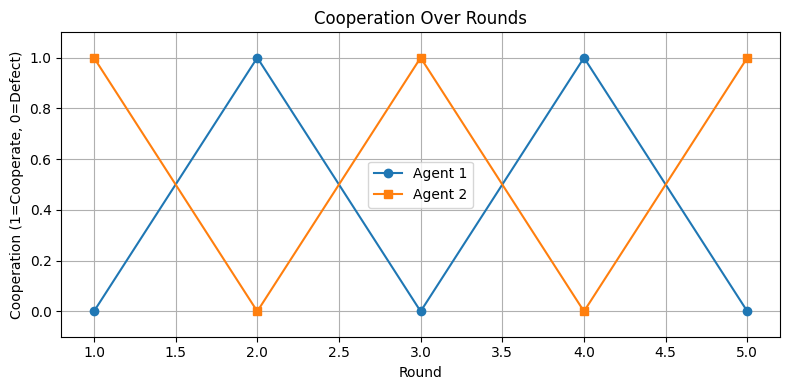

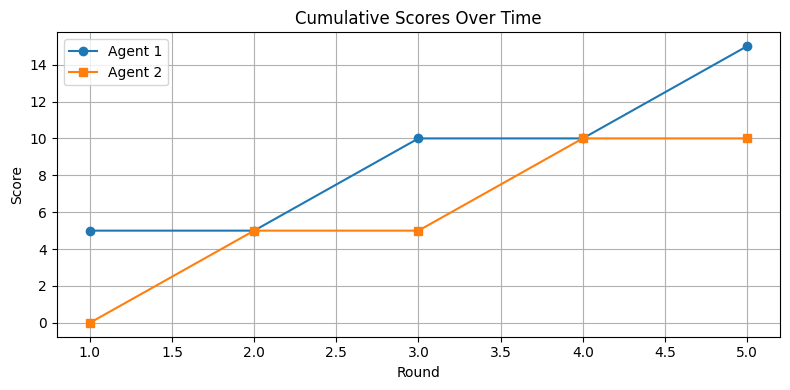

In [8]:
import pandas as pd
import matplotlib.pyplot as plt


df = pd.DataFrame(final_state["history"], columns=["Agent1", "Agent2"])
df["Round"] = df.index + 1
df["Agent1_Coop"] = df["Agent1"].apply(lambda x: 1 if x == "Cooperate" else 0)
df["Agent2_Coop"] = df["Agent2"].apply(lambda x: 1 if x == "Cooperate" else 0)


plt.figure(figsize=(8, 4))
plt.plot(df["Round"], df["Agent1_Coop"], label="Agent 1", marker='o')
plt.plot(df["Round"], df["Agent2_Coop"], label="Agent 2", marker='s')
plt.title("Cooperation Over Rounds")
plt.xlabel("Round")
plt.ylabel("Cooperation (1=Cooperate, 0=Defect)")
plt.ylim(-0.1, 1.1)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


score_df = pd.DataFrame(columns=["Round", "Agent1_Score", "Agent2_Score"])
a1, a2 = 0, 0
payoff = {
    ("Cooperate", "Cooperate"): (3, 3),
    ("Cooperate", "Defect"):    (0, 5),
    ("Defect", "Cooperate"):    (5, 0),
    ("Defect", "Defect"):       (1, 1)
}
for idx, (m1, m2) in enumerate(final_state["history"], 1):
    s1, s2 = payoff[(m1, m2)]
    a1 += s1
    a2 += s2
    score_df.loc[idx-1] = [idx, a1, a2]

plt.figure(figsize=(8, 4))
plt.plot(score_df["Round"], score_df["Agent1_Score"], label="Agent 1", marker='o')
plt.plot(score_df["Round"], score_df["Agent2_Score"], label="Agent 2", marker='s')
plt.title("Cumulative Scores Over Time")
plt.xlabel("Round")
plt.ylabel("Score")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()